### Promo impact analysis

#### Approach:

1. Calculated the revenue per transaction with promo and without promo and calculated the ratio
2. Looked at similar metrics by product category

#### Key takeaway:

1. At an overall level, transactions during promo period yeild 1.8x revenue when compared to non-promo period
2. Potatochips and cheesesnacks are the products that yeild highest incremental revenue during the promo period (2.2x and 2.1x) [This could be a cyclic impact which is worth drilling down into)

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [135]:
%cd /Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/IRI Data - Project/Data/Processed data

/Users/Deepthi/Documents/DSE/Q3_DSE220 - Machine Learning/IRI Data - Project/Data/Processed data


In [153]:
# Get the panel data (Used old version of the data as I was focusing only on 4 stores)
panel_demo_store_8_11 = pd.read_csv('panel_demo_store_8_11.csv',sep=',')

In [155]:
panel_demo_store_8_11.groupby(['iri_key','outlet']).panid.nunique()

iri_key  outlet
257871   GK        1541
642166   DK         116
650679   DK         117
651444   DK         291
Name: panid, dtype: int64

In [138]:
panel_demo_store_8_11.head()

,panid,week,minute,units,outlet,dollars,iri_key,colupc,ou,est_acv,...,race2,race3,microwave,device_type,zipcode,fipscode,market_based_upon_zipcode,iri_geography_number,ext_fact,cnt
0,1116608,1607,9587,2,DK,4.38,642166,11600014690,DR,1.65625,...,1,1,1,0,1201,25003,204,1,1,4
1,1408492,1632,8079,1,DK,1.12,642166,11600015840,DR,1.65625,...,1,1,1,0,1201,25003,204,1,1,4
2,1809632,1584,6998,2,DK,2.72,642166,11600015840,DR,1.65625,...,1,1,1,0,1201,25003,204,1,1,4
3,1809632,1604,6626,4,DK,5.32,642166,11600015990,DR,1.65625,...,1,1,1,0,1201,25003,204,1,1,4
4,1163584,1615,651,2,DK,3.00,642166,11600016490,DR,1.65625,...,1,1,1,0,1201,25003,204,1,1,4


In [139]:
## Got this promo flag using the query 'promo_data-query.sql'

promo_data = pd.read_csv('promo_data.txt',sep=';',header=None)
promo_data.columns = ['iri_key', 'store_type', 'week', 'upc2', 'pr']

In [140]:
promo_data.head()

,iri_key,store_type,week,upc2,pr
0,257871,drug,1656,27469005047,1
1,651444,drug,1264,52840000906,1
2,257871,drug,1496,17797508006,1
3,257871,drug,1538,17469006101,1
4,257871,drug,1668,11600005940,1


In [141]:
# Combine the two dataframes
combined_with_promo = pd.merge(panel_demo_store_8_11,promo_data, how = 'left',on = ['iri_key','week','upc2'])
combined_with_promo['pr'] = combined_with_promo['pr'].fillna(0)

In [142]:
combined_with_promo2 = combined_with_promo[['week','iri_key','l2','dollars','units','pr']].copy()

In [143]:
combined_with_promo3 = combined_with_promo2.groupby(['iri_key','week','l2','pr']).mean().reset_index()

combined_with_promo3.head()

,iri_key,week,l2,pr,dollars,units
0,257871,1479,CHEESE SNACKS,0,1.581538,1.076923
1,257871,1479,CHEESE SNACKS,1,3.120000,1.000000
2,257871,1479,CORN SNACKS (NO TORTILLA CHIPS),0,2.994444,1.111111
3,257871,1479,CORN SNACKS (NO TORTILLA CHIPS),1,4.240000,1.000000
4,257871,1479,OTHER SALTED SNACKS (NO NUTS),0,2.828889,1.222222


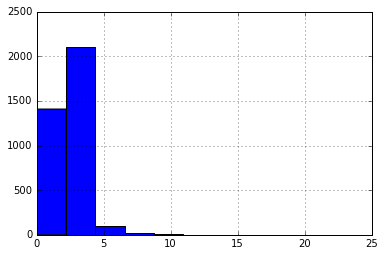

In [144]:
# Treat outliers

temp = combined_with_promo3['dollars'].copy()
temp.sort(inplace = True)
temp.hist()
plt.show()

In [145]:
combined_with_promo3=combined_with_promo3[combined_with_promo3['dollars']<=5]

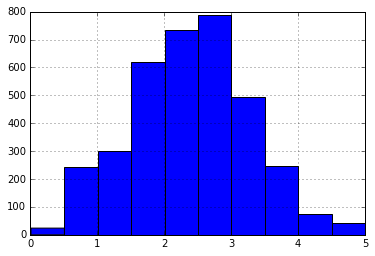

In [146]:
temp = combined_with_promo3['dollars'].copy()
temp.sort(inplace = True)
temp.hist()
plt.show()

In [147]:
## Used this to analyze data in Excel 
# (combined_with_promo3.groupby(['iri_key','l2','pr']).sum().reset_index())[['iri_key','l2','pr','dollars']].to_csv('promo_dollar_sum.csv')
# (combined_with_promo3.groupby(['iri_key','l2','pr']).count().reset_index())[['iri_key','l2','pr','dollars']].to_csv('promo_dollar_count.csv')

In [148]:
# Calculate the total impact of promo for the 4 stores

# Aggregate the data by store
dollar_impact = (combined_with_promo3.groupby(['pr']).mean().reset_index())[['pr','dollars']]

# Get mean revenue with and without promo
with_promo = list(dollar_impact[dollar_impact['pr']==1]['dollars'])
without_promo = list(dollar_impact[dollar_impact['pr']==0]['dollars'])

# Calculate the % impact
print round((with_promo[0] - without_promo[0])*100/without_promo[0],2),'%'


11.77 %


In [149]:
# Calculate the impact of promo for each store

# Aggregate the data by store
dollar_impact = (combined_with_promo3.groupby(['iri_key','pr']).mean().reset_index())[['iri_key','pr','dollars']]

# Pivot the data to get promo flag on the columns
dollar_impact2 = pd.pivot_table(dollar_impact, values='dollars', index=['iri_key'],columns=['pr'], aggfunc=np.sum).reset_index()
dollar_impact2.columns = ['iri_key','rev_without_promo','rev_with_promo']

# Calculate the impact of promo for every product category in every store
dollar_impact2['incr_rev'] = ((dollar_impact2['rev_with_promo'] - dollar_impact2['rev_without_promo'])*100/dollar_impact2['rev_without_promo']).apply(lambda x: x.round(2))
dollar_impact2.sort(['iri_key','incr_rev'],ascending = [True,False])

,iri_key,rev_without_promo,rev_with_promo,incr_rev
0,257871,2.523892,2.729094,8.13
1,642166,2.113122,2.176996,3.02
2,650679,1.722280,1.833306,6.45
3,651444,1.978923,2.179955,10.16


In [150]:
# Aggregate the data by store-product
dollar_impact = (combined_with_promo3.groupby(['iri_key','l2','pr']).mean().reset_index())[['iri_key','l2','pr','dollars']]

# Pivot the data to get promo flag on the columns
dollar_impact2 = pd.pivot_table(dollar_impact, values='dollars', index=['iri_key','l2'],columns=['pr'], aggfunc=np.sum).reset_index()
dollar_impact2.columns = ['iri_key','l2','rev_without_promo','rev_with_promo']

# Calculate the impact of promo for every product category in every store
dollar_impact2['incr_rev'] = ((dollar_impact2['rev_with_promo'] - dollar_impact2['rev_without_promo'])*100/dollar_impact2['rev_without_promo']).apply(lambda x: x.round(2))
dollar_impact2.sort(['iri_key','incr_rev'],ascending = [True,False])

,iri_key,l2,rev_without_promo,rev_with_promo,incr_rev
0,257871,CHEESE SNACKS,2.215652,2.636067,18.97
1,257871,CORN SNACKS (NO TORTILLA CHIPS),2.321135,2.696103,16.15
2,257871,OTHER SALTED SNACKS (NO NUTS),2.798955,3.139537,12.17
4,257871,POTATO CHIPS,2.643355,2.899213,9.68
3,257871,PORK RINDS,1.958264,2.043846,4.37
5,257871,PRETZELS,2.430670,2.488395,2.37
7,257871,TORTILLA/TOSTADA CHIPS,3.020080,2.934544,-2.83
6,257871,READY-TO-EAT POPCORN/CARAMEL COR,2.351571,1.997780,-15.04
12,642166,PRETZELS,1.889020,2.437500,29.04
14,642166,TORTILLA/TOSTADA CHIPS,2.233000,2.694286,20.66


In [151]:
# Store profiling
stores = dollar_impact2['iri_key'].drop_duplicates()

for i in stores:
    temp = combined_with_promo[combined_with_promo['iri_key'] == i][['panid','combined_pre_tax_income_of_hh','family_size',
                          'age_group_applied_to_female_hh','age_group_applied_to_male_hh',
                          'occupation_code_of_female_hh','occupation_code_of_male_hh','pr','l2']].copy()


    temp2=temp.drop_duplicates()

    temp2 = temp2.fillna(0) ## Treat NaN
    temp2.replace('99',0,inplace=True) ## Treat the extreme value 99 
    temp2.replace('98',0,inplace=True) ## Treat the extreme value 98
#     temp2 = temp2.convert_objects(convert_numeric=True) ## Convert all the columns to numeric values
    temp2 = temp2.fillna(0) ## Replace NaNs
    temp2['age_group_applied_to_male_hh'].replace(7,0,inplace=True) ## Convert the extreme value 7 to 0 to keep NAs consistent
    temp2['age_group_applied_to_female_hh'].replace(7,0,inplace=True) ## Convert the extreme value 7 to 0 to keep NAs consistent


    temp2['income_per_person'] = temp2['combined_pre_tax_income_of_hh']/(temp2['family_size']+1)
    temp2['age_group'] = temp2[['age_group_applied_to_male_hh','age_group_applied_to_female_hh']].mean(axis=1)
#     temp2['education'] = temp2[['education_level_reached_by_male_hh','education_level_reached_by_female_hh']].mean(axis=1)
    temp2['occupation'] = temp2[['occupation_code_of_male_hh','occupation_code_of_female_hh']].mean(axis=1)
    # data_for_modeling['number_of_tvs'] = data_for_modeling[['all_tvs','cabl_tvs']].mean(axis=1)

    temp3 = temp2[['panid','pr','age_group','l2']].copy()

    temp3[['panid','pr','age_group']] = temp3[['panid','pr','age_group']].convert_objects(convert_numeric=True).apply(lambda x: x.round()).drop_duplicates()
    temp4=temp3.copy()
    temp5 = temp4.groupby(['age_group','l2']).panid.nunique()

    print '***************************' , i , '***************************'
    print pd.DataFrame(temp5).reset_index().sort('panid',ascending = False)

*************************** 257871 ***************************
    age_group                                l2  panid
43          6                      POTATO CHIPS    208
27          4                      POTATO CHIPS    181
30          4            TORTILLA/TOSTADA CHIPS    172
20          3                      POTATO CHIPS    164
12          2                      POTATO CHIPS    124
35          5                      POTATO CHIPS    120
23          3            TORTILLA/TOSTADA CHIPS    118
38          5            TORTILLA/TOSTADA CHIPS    110
15          2            TORTILLA/TOSTADA CHIPS    108
46          6            TORTILLA/TOSTADA CHIPS    103
26          4     OTHER SALTED SNACKS (NO NUTS)     87
41          6     OTHER SALTED SNACKS (NO NUTS)     80
18          3     OTHER SALTED SNACKS (NO NUTS)     65
10          2     OTHER SALTED SNACKS (NO NUTS)     64
33          5     OTHER SALTED SNACKS (NO NUTS)     63
28          4                          PRETZELS     49
44